In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path
from pathlib import Path
import seaborn as sns
# from pyramid.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from ARIMA_PermEnt import weighted_perm_entropy, min_weighted_perm_entropy
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from statsmodels.tsa.stattools import adfuller
import math
import time

plt.style.use('seaborn-whitegrid')
%matplotlib inline  

In [3]:

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
#in-sample prediction
def in_sample_prediction(ts):
    modl = auto_arima(ts, max_q=3, m=7,
                               seasonal=True,
                               trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)

    pred = modl.predict_in_sample()
#     pred = pd.DataFrame(pred,index = ts.index,columns=['Prediction'])
#     pd.concat([ts,pred],axis=1).plot()
    # Print the error:
#     print("Test NRMSE: %.3f" % (np.sqrt(mean_squared_error(ts, pred))/np.mean(ts)))
    return (np.sqrt(mean_squared_error(ts, pred))/np.mean(ts))

In [5]:
#most significant autocorrelation lag
def max_lag_autocorr(ts,lags=7):
    ac1 = 0
    max_lag = 0
    for i in range(1,lags+1):
        ac = np.abs(ts.autocorr(lag=i))
        if ac > ac1:
            ac1 = ac
            max_lag = i
    return max_lag , ac1

In [6]:
def plot_entropy(df_results, p_sample, label):
    df1 = df_results[df_results.hashtag==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['entropy'][p_sample[0]]]+[df['entropy_sample'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=2, alpha=0.5)
    y_q1 = [df_q1['entropy'][p_sample[0]]]+[df_q1['entropy_sample'][p] for p in p_sample]
    y_q3 = [df_q3['entropy'][p_sample[0]]]+[df_q3['entropy_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)
    
    return x,y
    

def plot_autocorr(df_results, p_sample, label):
    df1 = df_results[df_results.hashtag==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['autocorr'][p_sample[0]]]+[df['autcorr_sample'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=2, alpha=0.8)
    y_q1 = [df_q1['autocorr'][p_sample[0]]]+[df_q1['autcorr_sample'][p] for p in p_sample]
    y_q3 = [df_q3['autocorr'][p_sample[0]]]+[df_q3['autcorr_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y

    
    
def plot_entropy_ratio(df_results, p_sample, label):
    df1 = df_results[df_results.hashtag==label]
    df1['ratio'] =  df1['entropy_sample']/df1['entropy']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    l = "#"+label+'('+str(df1['popularity'].values[0])+')'

    plt.plot(x,y,label=l ,linewidth=1, alpha=0.8)
    y_q1 = [1.0]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.0]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)    
    
    return x,y
    
    
def plot_autocorr_ratio(df_results, p_sample, label):
    df1 = df_results[df_results.hashtag==label]
    df1['ratio'] =  df1['autcorr_sample']/df1['autocorr']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=1, alpha=0.8)
    y_q1 = [1.]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y
    
def plot_autocorr_ratio_norm(df_results, p_sample, label):
    df1 = df_results[df_results.hashtag==label]
    df1['ratio'] =  df1['autcorr_sample']/df1['autocorr']
    
    df_results['p2var'] = df_results['sample_rate']*df_results['sample_rate']*df_results['var']
    df_results['x_norm'] = df_results['p2var']/(df_results['p2var']+df_results['sample_rate']*(1.-df_results['sample_rate'])*df_results['mean'])
    df_results.head()
    
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=1)
    y_q1 = [1.]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 

In [50]:
def sample_entropy_autocorr(df, n=10, p_sample = [0.8, 0.5, 0.1]):
    n_samples = 100
    hashtags = df.groupby(['hashtag']).size().reset_index(name='count').sort_values(['count'], ascending=False)
    hashtags =  hashtags.head(n)['hashtag'].values
    results = []
    for h in hashtags:
        df_hash = df.loc[df['hashtag']==h]
        df_hash['time'] = pd.to_datetime(df_hash['time']).apply(lambda x: x.strftime('%Y-%m-%d'))
        ts = df_hash.groupby(['time'],as_index=False).count()
        ts['time'] = pd.to_datetime(ts['time'])
        ts.set_index('time', inplace=True)
        ts=ts['hashtag']
        ts = ts +100 #autocorelation and entropy are shitf invariant, and avoids removing all points when sampling
        #fill missing dates with 0
        all_days = pd.date_range(ts.index.min(), ts.index.max(), freq='D')
        ts = ts.reindex(all_days,fill_value=0)

        order, delay = min_weighted_perm_entropy(ts, min_order=3, max_order=5, min_delay=1, max_delay=7, normalize=True)
        entropy = weighted_perm_entropy(ts, order=order,delay=delay, normalize=True)
        max_lag, autocorr =  max_lag_autocorr(ts, lags=10)
        var = np.var(ts)
        mean = np.mean(ts)
        
        print(h, entropy, order, delay )
        k = 0
        while k < n_samples:
            k+=1
            for p in p_sample:
                ts_sample = ts.apply(lambda x: np.random.binomial(x, p, size = 1)[0] if not np.isnan(x) else None )
                entropy_sample = weighted_perm_entropy(ts_sample, order=order, delay=delay, normalize=True)
                autcorr_sample = np.abs(ts_sample.autocorr(lag=max_lag))
                results.append([h,entropy_sample,entropy,entropy_sample/entropy,order,p, autocorr, autcorr_sample, max_lag, var, mean])
#                 print(h, entropy, entropy_sample, order, autocorr, autcorr_sample, max_lag, p)
    
    df = pd.DataFrame.from_records(results,columns=['hashtag','entropy_sample','entropy','ratio','order','sample_rate','autocorr','autcorr_sample','max_lag','var','mean']).dropna()
    print('finished')
    return df



# MAIN

In [35]:
data_folder = Path("Data/twitter/")
result_folder = Path("Results/twitter/")
fig_folder = Path("Figures/twitter/")

actions = pd.read_csv(data_folder/"action_hashtag_top100hashtags.csv")
actions = actions[actions.time >= '2014-06-01']
actions['time'] = pd.to_datetime(actions['time']).apply(lambda x: x.strftime('%Y-%m-%d'))



In [37]:
#summary of data
n = 100
hashtags = actions.groupby(['hashtag']).size().reset_index(name='count').sort_values(['count'], ascending=False)
hashtags =  hashtags.head(n)['hashtag'].values

actions = actions.loc[actions['hashtag'].isin(hashtags)]
# actions.to_csv(data_folder/"action_hashtag_top100hashtags.csv", index=False)

In [38]:
print('users = ', len(actions.user.unique()) )
print('activity = ', actions.user.count() )
# df.groupby(['hashtag']).count().describe()
# df.groupby(['user']).count().describe()
actions.groupby(['time']).count().describe()

users =  233108
activity =  1269348


,user,hashtag
count,114.000000,114.000000
mean,11134.631579,11134.631579
std,6941.096368,6941.096368
min,302.000000,302.000000
25%,5936.000000,5936.000000
50%,9288.000000,9288.000000
75%,15675.250000,15675.250000
max,34184.000000,34184.000000


In [51]:
n = 100
p_sample = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]


result_file = Path(result_folder/'results_twitter_hashtags.csv')
if os.path.exists(result_file):
    df_results = pd.read_csv(result_file)
else:
    #run once to compute and save entropy on data
    #Takes several minutes
    df_results = sample_entropy_autocorr(actions,n=n, p_sample=p_sample)
    df_results.to_csv(result_file, index=False)

    
#add popularity of hashtag
hashtags = actions.groupby(['hashtag']).size().reset_index(name='popularity').sort_values(['popularity'], ascending=False)
# hashtags.head()
df_results = df_results.merge(hashtags, on='hashtag')

df_results.head()

<ipython-input-50-685166c26021>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hash['time'] = pd.to_datetime(df_hash['time']).apply(lambda x: x.strftime('%Y-%m-%d'))


ferguson 0.5315672788958701 4 5
gaza 0.5532587006765319 4 6
ff 0.47107716350879486 5 7
worldcup 0.5695633489463792 5 5
usa 0.4811993474214119 5 5
tcot 0.7238022240560915 4 1
win 0.7719305840502984 4 7
mtvhottest 0.6679945834325307 4 4
mh17 0.0044865830622993754 3 7
quote 0.7371480279317659 4 6
ger 0.3991574590022252 5 5
israel 0.6561100386219002 4 6
edchat 0.7497429615158707 4 6
socialmedia 0.6895160731042791 4 7
giveaway 0.7324307389323229 4 7
1 0.7563488199944502 4 1
tbt 0.39910819142347126 5 7
gazaunderattack 0.7130917985569506 4 7
leadership 0.7841388855641599 4 6
travel 0.7791422256502301 4 6
worldcup2014 0.620473626965522 5 5
rt 0.6588572578056654 5 7
mikebrown 0.23345659946485645 3 7
marketing 0.8023985660648882 4 6
edtech 0.8126354825752287 4 7
art 0.7505975335351283 4 4
sdcc 0.333987956150939 5 1
uniteblue 0.7127514380946338 5 1
nyc 0.8574363855708489 4 6
bra 0.4439687623470102 5 4
isis 0.6736408177012697 5 1
auspol 0.8558423325476635 4 5
icebucketchallenge 0.5116081802301932 

,hashtag,entropy_sample,entropy,ratio,order,sample_rate,autocorr,autcorr_sample,max_lag,var,mean,popularity
0,ferguson,0.531633,0.531567,1.000123,4,0.9,0.789325,0.788425,1,1.172826e+07,1303.629213,111223
1,ferguson,0.531625,0.531567,1.000109,4,0.8,0.789325,0.788985,1,1.172826e+07,1303.629213,111223
2,ferguson,0.531670,0.531567,1.000192,4,0.7,0.789325,0.788471,1,1.172826e+07,1303.629213,111223
3,ferguson,0.531986,0.531567,1.000788,4,0.6,0.789325,0.787125,1,1.172826e+07,1303.629213,111223
4,ferguson,0.532109,0.531567,1.001019,4,0.5,0.789325,0.784844,1,1.172826e+07,1303.629213,111223


In [52]:
df_results['ratio'] =  df_results['autcorr_sample']/df_results['autocorr']
df_results['p2var'] = df_results['sample_rate']*df_results['sample_rate']*df_results['var']
df_results['x_norm'] = df_results['p2var']/(df_results['p2var']+df_results['sample_rate']*(1.-df_results['sample_rate'])*df_results['mean'])
# df_results.plot.scatter(x='x_norm',y='ratio')


# df_results


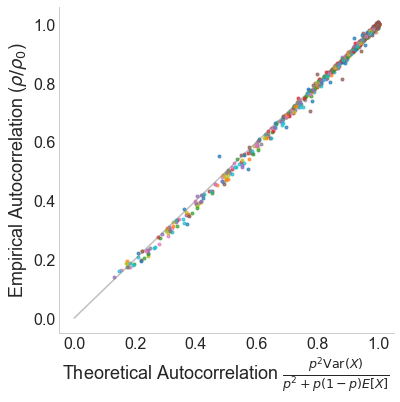

In [53]:
df = df_results.groupby(['hashtag','sample_rate']).mean()
df = df.reset_index()
df['hashtag'] = df['hashtag'].astype('category')
# sns.lmplot(x="x_norm", y="ratio", scatter_kws={"s": 1,'alpha':0.05}, data=df)
fig, ax = plt.subplots(figsize=(6, 6))


for h in df_results.hashtag.unique():
    plot_df = df[df.hashtag==h]
    plt.plot(plot_df.x_norm, plot_df.ratio, '.', alpha=0.7 )

plt.plot([0,1],[0,1], color='grey', alpha=0.5)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel(r'Theoretical Autocorrelation $\frac{ p^2 \mathrm{Var}(X)}{p^2 + p(1-p)E[X]}$')
plt.ylabel(r'Empirical Autocorrelation ($\rho/\rho_0$)')
plt.savefig(fig_folder/'hashtag_theoretical.pdf', bbox_inches='tight')

In [54]:
hashtags = actions.groupby(['hashtag']).size().reset_index(name='count').sort_values(['count'], ascending=False)
hashtags =  hashtags.head(n)['hashtag'].values

In [55]:
coef, p = kendalltau(df_results.ratio, df_results.sample_rate)#spearmanr
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.5f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.413
Samples are correlated (reject H0) p=0.000


<ipython-input-6-62207c10b64d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ratio'] =  df1['entropy_sample']/df1['entropy']


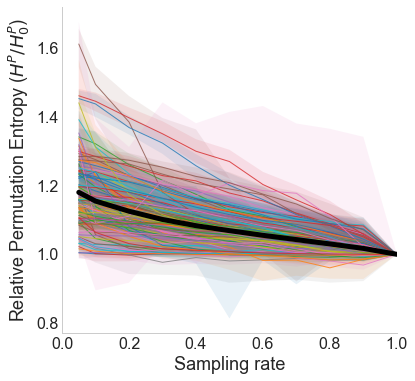

In [56]:
#plot entropy



NUM_COLORS = 100

plt.rc('legend',fontsize='x-large') 
yy = []
xx = []
fig, ax = plt.subplots(figsize=(6, 6))

# cm = plt.get_cmap('gist_ncar')
# cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
# scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

# ax.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

for h in df_results.hashtag.unique():
    if h=='riprobinwilliams' or h=='mh17': #remove because it messes with the scale
        continue
    x,y = plot_entropy_ratio(df_results, p_sample=p_sample, label=h)
    if np.max(y)>10:
        print(h,np.max(y))
    yy.append(y)
    xx.append(x)

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=5, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')


# leg = plt.legend(bbox_to_anchor=(1, 1.5), ncol=4)
# leg.set_title("Hashtag (Popularity)", prop = {'size':'x-large'})
plt.xlim(0,1.)
# plt.ylim(0.9,2.4)
# plt.yscale('log')
# ax.set_yscale('log', basey=2)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Sampling rate')
plt.ylabel(r'Relative Permutation Entropy ($H^P/H^P_0$)')
plt.savefig(fig_folder/'hashtag_entropy_ratio.pdf', bbox_inches='tight')

Text(0, 0.5, 'Permutation Entropy ($H^P/)')

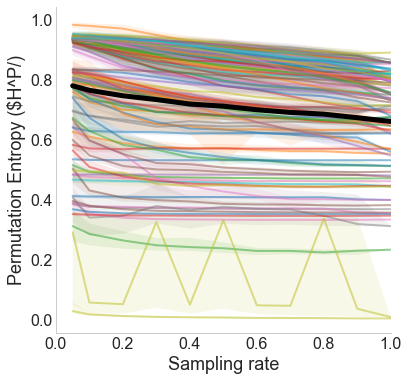

In [58]:
#plot entropy

yy = []
xx = []
fig, ax = plt.subplots(figsize=(6, 6))
for h in df_results.hashtag.unique():
#     if h=='riprobinwilliams' or h=='mh17':
#         continue
    x,y = plot_entropy(df_results, p_sample=p_sample, label=h)
    yy.append(y)
    xx.append(x)

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=5, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

    
# plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.xlim(0,1.)
# plt.ylim(0.9,2.4)
# plt.yscale('log')
# ax.set_yscale('log', basey=2)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Sampling rate')
plt.ylabel(r'Permutation Entropy ($H^P/)')
# plt.savefig(fig_folder/'epidemic_entropy_W52.pdf', bbox_inches='tight')

/Users/aabeliuk/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


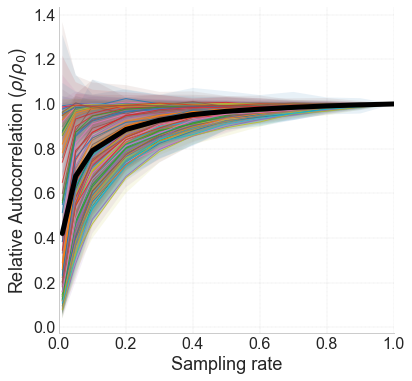

In [37]:
#plot autocorrelation 

yy = []
xx = []
fig, ax = plt.subplots(figsize=(6, 6))
for h in df_results.hashtag.unique():
    x,y = plot_autocorr_ratio(df_results, p_sample, label=h)
    yy.append(y)
    xx.append(x)

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=5, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

    
# plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel(r'Relative Autocorrelation ($\rho/\rho_0$)')
plt.savefig(fig_folder/'hashtag_autocorr_ratio.pdf', bbox_inches='tight')


# OLD

In [ ]:
#remove days with less than 1 event
# actions = actions.loc[actions['count']>1]
# sample_df = actions.groupby(['hashtag']).sum().reset_index().sort_values(['count'], ascending=False)
# sample_df.head()

# actions.groupby(['hashtag']).sum().reset_index().sort_values(['count'], ascending=False)

In [ ]:
sample_df = actions.groupby(['hashtag'])['time'].nunique().reset_index(name='count').sort_values(['count'], ascending=False)
hashtag_df = sample_df.loc[sample_df['count'] >= 30]['hashtag']
sample_df = actions.groupby(['hashtag']).size().reset_index(name='count').sort_values(['count'], ascending=False)
sample_df = sample_df.loc[sample_df['hashtag'].isin(hashtag_df )]
sample_df.head(40)

In [ ]:
hashtag = 'riprobinwilliams'
df = actions.loc[actions['hashtag']==hashtag]
# df = df[df.time <= '2014-09-01']
# df['time'] = pd.to_datetime(df['time']).apply(lambda x: x.strftime('%Y-%m-%d'))

ts = df.groupby(['time'],as_index=False).count()

# ts = df[['time','count']]
ts['time'] = pd.to_datetime(ts['time'])
ts = ts.loc[ts['hashtag']>10]
ts.set_index('time', inplace=True)
ts=ts['hashtag']
# ts = np.log(ts)
# ts = ts.diff()[1:]
ts.plot()
g = plot_acf(ts,lags=10)
g = plot_pacf(ts, lags=10)
ts.autocorr(lag=1)


In [ ]:
#in-sample prediction
start = time.time()
rmse = in_sample_prediction(ts)
# Print the error:
print("Test NRMSE: %.3f" % rmse)
end = time.time()
print(end - start)


In [ ]:
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
#random sample
df = df.loc[ pd.to_datetime(df['time']).isin(ts.index)]
df_sample = df.sample(frac=0.5)

ts = df_sample.groupby(['time'],as_index=False).count()
ts['time'] = pd.to_datetime(ts['time'])
ts.set_index('time', inplace=True)
ts=ts['hashtag']
# ts = np.log(ts)
# ts = ts.diff()[1:]
ts.plot()
# g = plot_acf(ts,lags=10)
# g = plot_pacf(ts, lags=10)
# ts.autocorr(lag=1)
ts.hist(bins = 10)

In [ ]:
weighted_perm_entropy(ts, order=3, delay=1, normalize=True)

In [ ]:
ts.hist(bins = 50)


In [ ]:
#in-sample prediction
rmse = in_sample_prediction(ts)
# Print the error:
print("Test NRMSE: %.3f" % rmse)

In [ ]:
#compute autocorrelation of top n most popular hashtags
def compute_autocorr_hashtag(hashtag, s_size, n_samples = 100, order = 7):
    lags = 7
#     s_size = [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
    autocorr = [[] for i in range(len(s_size))]    
    entropy = [[] for i in range(len(s_size))]   
    
    df = actions.loc[actions['hashtag']==hashtag]
    df['time'] = pd.to_datetime(df['time']).apply(lambda x: x.strftime('%Y-%m-%d'))

    ts = df.groupby(['time'],as_index=False).count()
    ts['time'] = pd.to_datetime(ts['time'])
    ts.set_index('time', inplace=True)
    ts=ts['hashtag']
    max_lag = 0
    ac1 = 0
    #most significant autocorrelation lag
#     en1 = ent.permutation_entropy(ts, order=order, delay=1, normalize=True)
    en1 = weighted_perm_entropy(ts, order=order, delay=1, normalize=True)
    for i in range(1,lags+1):
        ac = np.abs(ts.autocorr(lag=i))
        if ac > ac1:
            ac1 = ac
            max_lag = i

    #random sample
    i=0
    for f in s_size:
        ac2 = 0.
        en2 = 0.
        for k in range(n_samples):
            df_sample = df.sample(frac=f)
            ts = df_sample.groupby(['time'],as_index=False).count()
            ts['time'] = pd.to_datetime(ts['time'])
            ts.set_index('time', inplace=True)
            ts=ts['hashtag']
            ts = ts.asfreq('D')
            ts = ts.fillna(0)
            ac2 += np.abs(ts.autocorr(lag=max_lag))
            en2 += weighted_perm_entropy(ts, order=order, delay=1, normalize=True)
#             en2 += ent.permutation_entropy(ts, order=order, delay=1, normalize=True)

        autocorr[i].append((ac2/n_samples))
#             entropy[i].append((en1)/(en2/n_samples))
        entropy[i].append(en2/n_samples/en1)
        i+=1
    return autocorr, entropy

In [ ]:
#compute autocorrelation of top n most popular hashtags
def compute_autocorr(n=50, n_samples = 100, order = 7):
    hashtags = sample_df.head(n)['hashtag'].values
    lags = 7
    s_size = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
    autocorr = [[] for i in range(len(s_size))]    
    entropy = [[] for i in range(len(s_size))]   
    for h in hashtags:
        print(h)
        df = actions.loc[actions['hashtag']==h]
        df['time'] = pd.to_datetime(df['time']).apply(lambda x: x.strftime('%Y-%m-%d'))

        ts = df.groupby(['time'],as_index=False).count()
        ts['time'] = pd.to_datetime(ts['time'])
        ts.set_index('time', inplace=True)
        ts=ts['hashtag']
        max_lag = 0
        ac1 = 0
        #most significant autocorrelation lag
        en1 = ent.permutation_entropy(ts, order=order, delay=1, normalize=True)
        for i in range(1,lags+1):
            ac = np.abs(ts.autocorr(lag=i))
            if ac > ac1:
                ac1 = ac
                max_lag = i

        #random sample
        i=0
        for f in s_size:
            ac2 = 0.
            en2 = 0.
            for k in range(n_samples):
                df_sample = df.sample(frac=f)
                ts = df_sample.groupby(['time'],as_index=False).count()
                ts['time'] = pd.to_datetime(ts['time'])
                ts.set_index('time', inplace=True)
                ts=ts['hashtag']
                ts = ts.asfreq('D')
                ts = ts.fillna(0)
                ac2 += np.abs(ts.autocorr(lag=max_lag))
#                 en2 += weighted_perm_entropy(ts, order=order, delay=1, normalize=True)
                en2 += ent.permutation_entropy(ts, order=order, delay=1, normalize=True)

            autocorr[i].append((ac2/n_samples)/ac1)
#             entropy[i].append((en1)/(en2/n_samples))
            entropy[i].append(en2/n_samples)
            i+=1
    return autocorr, entropy


def plot_entropy(orders=[3,4,5,6,7]):
    plt.figure(figsize=(5, 4))
    s_size = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
    for order in orders:
        autocorr, entropy = compute_autocorr(n=1, n_samples=10, order=order)
        y_en = []
        e_en = []
        for i in range(len(autocorr)):
            y_en.append(np.mean(entropy[i]))
            e_en.append(np.std(entropy[i])/np.sqrt(n_samples))

        x = 1.-np.array(s_size)
        plt.errorbar(x, y_en, yerr=e_en, fmt='-o')
        plt.legend(['dim ='+str(order)])

    plt.xlabel('Drop out rate')
    plt.ylabel('Relative Permutation Entropy')

    
def plot_entropy_hashtag(orders=[3,4,5,6,7]):
    plt.figure(figsize=(5, 4))
    for order in orders:
        autocorr, entropy = compute_autocorr(n=2, n_samples=10, order=order)
        y_en = []
        e_en = []
        for i in range(len(autocorr)):
            y_en.append(np.mean(entropy[i]))
            e_en.append(np.std(entropy[i])/np.sqrt(n_samples))

        x = 1.-np.array(s_size)
        plt.errorbar(x, y_en, yerr=e_en, fmt='-o')
        plt.legend(['dim ='+str(order)])

    plt.xlabel('Drop out rate')
    plt.ylabel('Relative Permutation Entropy')

In [ ]:
h = 'gazaunderattack'
f = 0.6
df = actions.loc[actions['hashtag']==h]
df_sample = df.sample(frac=f)
ts = df_sample.groupby(['time'],as_index=False).count()
ts['time'] = pd.to_datetime(ts['time'])
ts.set_index('time', inplace=True)
ts=ts['hashtag']
ts = ts.asfreq('D')
ts = ts.fillna(0)
weighted_perm_entropy(ts, order=7, delay=1, normalize=True)
# plt.figure(figsize=(10, 5))
# ts.plot()

In [ ]:
n=10
s_size = [1.0, 0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
x = 1.-np.array(s_size)
hashtags = sample_df.head(n)['hashtag'].values
plt.figure(figsize=(10, 8))
rel_entropy = []
for h in hashtags:
    autocorr, entropy = compute_autocorr_hashtag(h, s_size, n_samples = 5, order = 3)
    rel_entropy.append(np.round(entropy, 2)[5][0])
    plt.plot(x, autocorr, label=h)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

In [ ]:
# autocorr, entropy = compute_autocorr(n=50, n_samples=10, order=10)
plot_entropy(orders=[7])

In [ ]:
plt.figure(figsize=(5, 4))
x = 1.-np.array(s_size)

plt.errorbar(x, y_en, yerr=e_en, fmt='-o', color='black')
plt.xlabel('Drop out rate')
plt.ylabel('Relative Permutation Entropy')
# plt.savefig(fig_folder/'Twitter_auto.pdf', bbox_inches='tight')


In [ ]:
plt.errorbar(x, y_au, yerr=e_au, fmt='-o', color='black')
plt.xlabel('Drop out rate')
plt.ylabel('Relative autocorrelation')
# plt.savefig(fig_folder/'Twitter_auto.pdf', bbox_inches='tight')

In [ ]:
#compute RMSE of top n most popular hashtags
hashtags = sample_df.head(50)['hashtag'].values


n_samples = 5
s_size = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
s_size = [0.4,0.2,0.1,0.05,0.01]
rmse = [[] for i in range(len(s_size))]    
for h in hashtags:
    start = time.time()
    print(h)
    
    df = actions.loc[actions['hashtag']==h]
    
    ts = df.groupby(['time'],as_index=False).count()
    ts['time'] = pd.to_datetime(ts['time'])
    ts = ts.loc[ts['hashtag']>50]
    ts.set_index('time', inplace=True)
    ts=ts['hashtag']

    rmse1 = in_sample_prediction(ts)
            
    df = df.loc[ pd.to_datetime(df['time']).isin(ts.index)]    
    #random sample
    i=0
    for f in s_size:
        rmse2=0
        for k in range(n_samples):
            df_sample = df.sample(frac=f)
            ts = df_sample.groupby(['time'],as_index=False).count()
            ts['time'] = pd.to_datetime(ts['time'])
            ts.set_index('time', inplace=True)
            ts=ts['hashtag']
            
            rmse2 += in_sample_prediction(ts)

        rmse[i].append((rmse2/n_samples)/rmse1)
        i+=1
    end = time.time()
    print(end - start)

In [ ]:
y = []
e = []
for i in range(len(rmse)):
    y.append(np.mean(rmse[i]))
    e.append(np.std(rmse[i])/np.sqrt(n_samples))

plt.figure(figsize=(5, 4))
x = 1.- np.array(s_size)
plt.errorbar(x, y, yerr=e, fmt='-o',color='black')
plt.xlabel('Drop out rate')
plt.ylabel('Relative normalized RMSE')
plt.savefig(fig_folder/'Twitter_rmse.pdf', bbox_inches='tight')

In [ ]:
import pickle
with open('rmse.pkl', 'wb') as f:
    pickle.dump(rmse, f)

# Conversation Clasification


In [ ]:
p_b = [] 
p_d = []
p_a = []
hashtags = sample_df.head(50)['hashtag'].values
for h in hashtags:
    df = actions.loc[actions['hashtag']==h]
    df['time'] = pd.to_datetime(df['time']).apply(lambda x: x.strftime('%W'))
    ts = df.groupby(['time'],as_index=False).count()
    ts.set_index('time', inplace=True)
    ts=ts['hashtag']
    
    id_max = ts.idxmax()
    total = ts.sum()*1.
    b = ts.loc[ts.index<id_max].sum()/total
    p_b.append(b)
    d = ts.loc[ts.index==id_max].sum()/total
    p_d.append(d)
    a = ts.loc[ts.index>id_max].sum()/total
    p_a.append(a)
#     print("pb,pd,pa", (pb,pd,pa))
    

In [ ]:

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(p_a,p_b)
plt.xlabel("pa")
plt.ylabel("pb")

for i, ent in enumerate(rel_entropy):
    ax.annotate(ent, (p_a[i], p_b[i]))